/tmp/ipykernel_5112/3673520586.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.drop(columns=["track_id", "artists", "album_name", "track_name", "track_genre"], inplace=True)


ward
0.5507112169079905
complete
0.9061091483317171
average
0.9061091483317171
single
0.9259588381908312


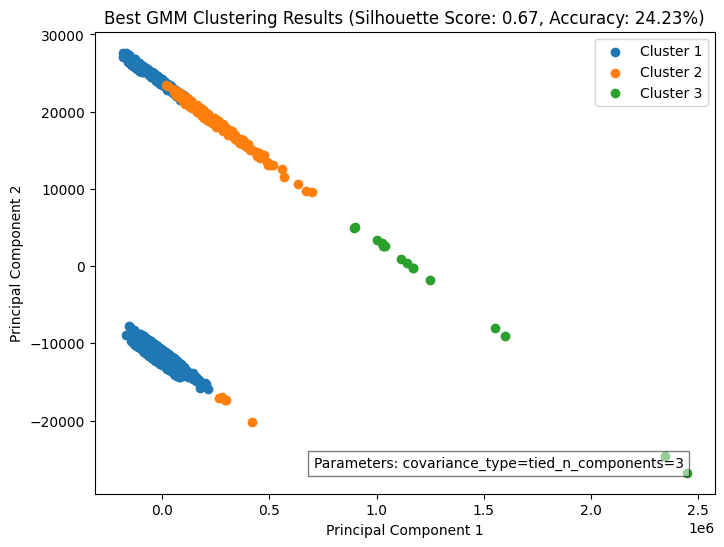

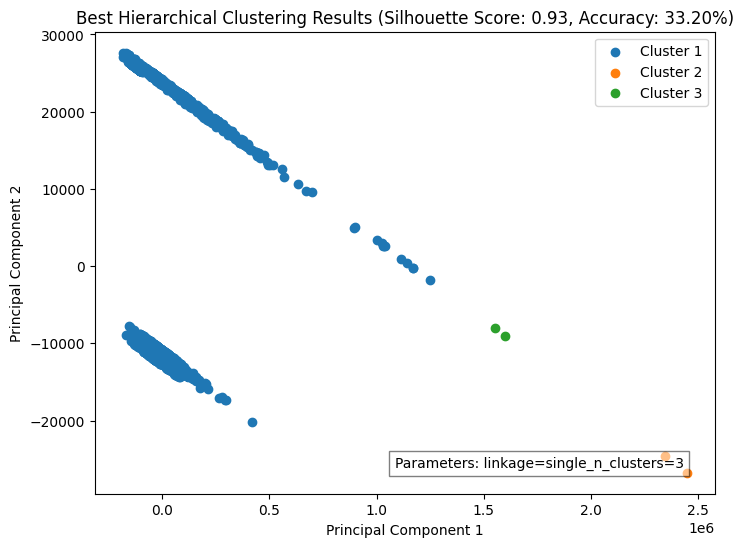

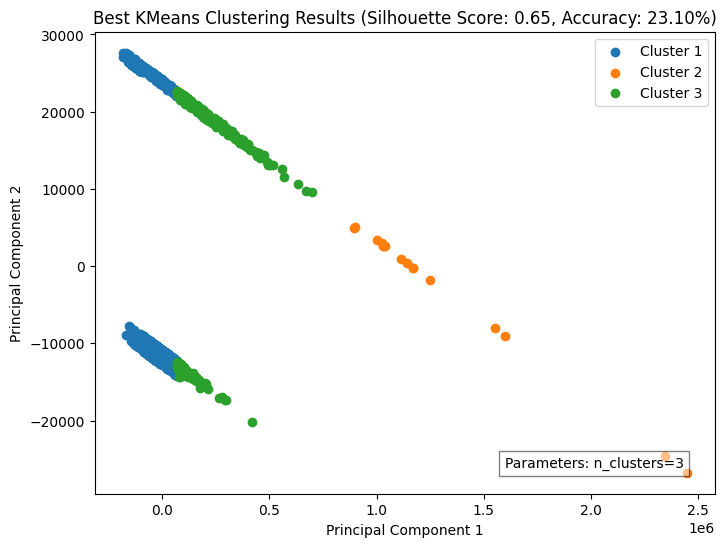

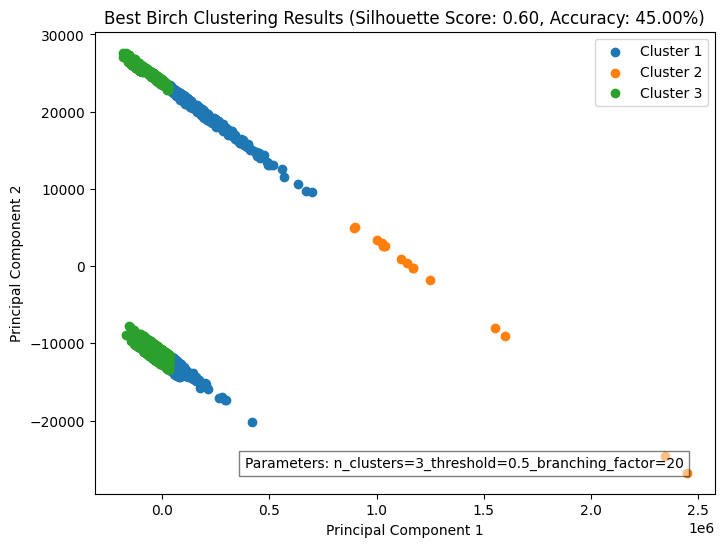

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


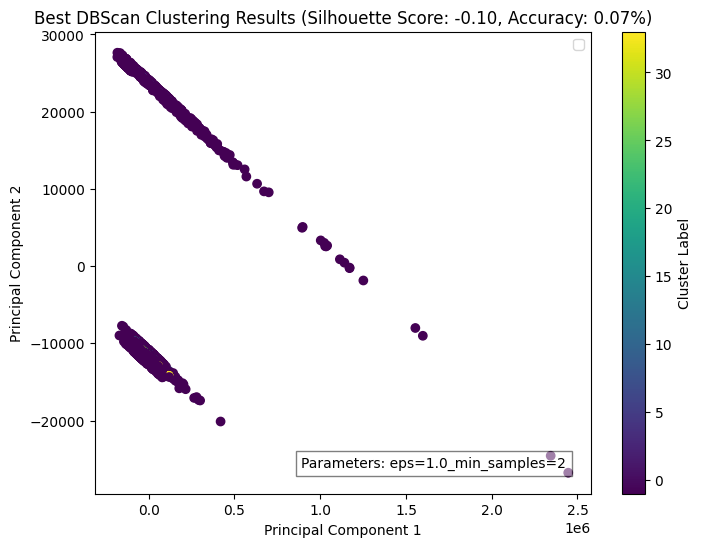

Overall best clustering method: Hierarchical with parameters linkage=single_n_clusters=3
Overall best silhouette score: 0.9259588381908312
Overall Best Clustering Result:
+----+--------------+-----------------------------+--------------------+------------+---------------------------------------------------------+
|    | Method       | Parameters                  |   Silhouette Score |   Accuracy | Model                                                   |
|----+--------------+-----------------------------+--------------------+------------+---------------------------------------------------------|
|  0 | Hierarchical | linkage=single_n_clusters=3 |           0.925959 |      0.332 | AgglomerativeClustering(linkage='single', n_clusters=3) |
+----+--------------+-----------------------------+--------------------+------------+---------------------------------------------------------+


In [95]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, Birch
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, accuracy_score
from tabulate import tabulate 
import numpy as np
from sklearn.metrics import davies_bouldin_score
data = pd.read_csv("dataset.csv")
accuracy_run=50
chosen_genres = ["hip-hop", "honky-tonk", "industrial"]
filtered_data = data[data['track_genre'].isin(chosen_genres)]
filtered_datacopy=filtered_data.copy()
# Drop problematic columns
filtered_data.drop(columns=["track_id", "artists", "album_name", "track_name", "track_genre"], inplace=True)

# Preprocessing
scaler = StandardScaler()
scaled_data = filtered_data
scaled_data2 = scaler.fit_transform(filtered_data)

# Calculate PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

best_cluster_results = []

# KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_data)
silhouette_avg = silhouette_score(scaled_data, cluster_labels)
accuracy = accuracy_score(data[data['track_genre'].isin(chosen_genres)].groupby('track_genre').ngroup(), cluster_labels)
best_cluster_results.append(("KMeans", "n_clusters=3", silhouette_avg, accuracy, kmeans))

# Hierarchical
linkage_methods = ['ward', 'complete', 'average', 'single']
for linkage_method in linkage_methods:
    hier_clustering = AgglomerativeClustering(n_clusters=3, linkage=linkage_method)
    cluster_labels = hier_clustering.fit_predict(scaled_data)
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    print(linkage_method)
    print(silhouette_avg)
    davies_bouldin_index = davies_bouldin_score(scaled_data, cluster_labels)
    accuracy_scores = []
    for x in range(1,accuracy_run):
       accuracy_scores.append(accuracy_score(data[data['track_genre'].isin(chosen_genres)].groupby('track_genre').ngroup(), cluster_labels))
    accuracy=np.mean(accuracy_scores)
    best_cluster_results.append(("Hierarchical", f"linkage={linkage_method}_n_clusters=3", silhouette_avg, accuracy, hier_clustering))

# DBScan
eps_values = [0.1, 0.5, 1.0]
min_samples_values = [2, 5, 10]
for eps_val in eps_values:
    for min_samples_val in min_samples_values:
        dbscan = DBSCAN(eps=eps_val, min_samples=min_samples_val)
        cluster_labels = dbscan.fit_predict(scaled_data2)
        if len(set(cluster_labels)) > 1:
            silhouette_avg = silhouette_score(scaled_data2, cluster_labels)
            accuracy_scores = []
            for x in range(1,accuracy_run):
                 accuracy_scores.append(accuracy_score(data[data['track_genre'].isin(chosen_genres)].groupby('track_genre').ngroup(), cluster_labels))
            accuracy=np.mean(accuracy_scores)
            best_cluster_results.append(("DBScan", f"eps={eps_val}_min_samples={min_samples_val}", silhouette_avg, accuracy, dbscan))

# Birch
thresholds = [0.1, 0.5, 1.0]
branching_factors = [20, 50, 100]
for threshold_val in thresholds:
    for branching_factor_val in branching_factors:
        birch = Birch(n_clusters=3, threshold=threshold_val, branching_factor=branching_factor_val)
        cluster_labels = birch.fit_predict(scaled_data)
        silhouette_avg = silhouette_score(scaled_data, cluster_labels)
        accuracy_scores = []
        for x in range(1,accuracy_run):
            accuracy_scores.append(accuracy_score(data[data['track_genre'].isin(chosen_genres)].groupby('track_genre').ngroup(), cluster_labels))
        accuracy=np.mean(accuracy_scores)
        best_cluster_results.append(("Birch", f"n_clusters=3_threshold={threshold_val}_branching_factor={branching_factor_val}", silhouette_avg, accuracy, birch))

# GMM
covariance_types = ['full', 'tied', 'diag', 'spherical']
for covariance_type_val in covariance_types:
    gmm = GaussianMixture(n_components=3, covariance_type=covariance_type_val)
    gmm.fit(scaled_data)
    cluster_labels = gmm.predict(scaled_data)

    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    accuracy_scores = []
    for x in range(1,accuracy_run):
        accuracy_scores.append(accuracy_score(data[data['track_genre'].isin(chosen_genres)].groupby('track_genre').ngroup(), cluster_labels))
    accuracy=np.mean(accuracy_scores)
    best_cluster_results.append(("GMM", f"covariance_type={covariance_type_val}_n_components=3", silhouette_avg, accuracy, gmm))

for method in set(result[0] for result in best_cluster_results):
    best_result = max((result for result in best_cluster_results if result[0] == method), key=lambda x: x[2])
    best_model = best_result[4]  # model is now at index 4 in the tuple
    cluster_labels = best_model.fit_predict(scaled_data)

    plt.figure(figsize=(8, 6))
    if isinstance(best_model, KMeans):
        for i in range(best_model.n_clusters):
            plt.scatter(pca_data[cluster_labels == i, 0], pca_data[cluster_labels == i, 1], label=f'Cluster {i+1}')
        plt.title(f'Best {method} Clustering Results (Silhouette Score: {best_result[2]:.2f}, Accuracy: {best_result[3]*100:.2f}%)')
    elif isinstance(best_model, AgglomerativeClustering):
        for i in range(best_model.n_clusters):
            plt.scatter(pca_data[cluster_labels == i, 0], pca_data[cluster_labels == i, 1], label=f'Cluster {i+1}')
        plt.title(f'Best {method} Clustering Results (Silhouette Score: {best_result[2]:.2f}, Accuracy: {best_result[3]*100:.2f}%)')
    elif isinstance(best_model, DBSCAN):
        plt.scatter(pca_data[:, 0], pca_data[:, 1], c=cluster_labels, cmap='viridis')
        plt.colorbar(label='Cluster Label')
        plt.title(f'Best {method} Clustering Results (Silhouette Score: {best_result[2]:.2f}, Accuracy: {best_result[3]*100:.2f}%)')
    elif isinstance(best_model, Birch):
        for i in range(len(set(cluster_labels))):
            plt.scatter(pca_data[cluster_labels == i, 0], pca_data[cluster_labels == i, 1], label=f'Cluster {i+1}')
        plt.title(f'Best {method} Clustering Results (Silhouette Score: {best_result[2]:.2f}, Accuracy: {best_result[3]*100:.2f}%)')
    elif isinstance(best_model, GaussianMixture):
        for i in range(best_model.n_components):
            plt.scatter(pca_data[cluster_labels == i, 0], pca_data[cluster_labels == i, 1], label=f'Cluster {i+1}')
        plt.title(f'Best {method} Clustering Results (Silhouette Score: {best_result[2]:.2f}, Accuracy: {best_result[3]*100:.2f}%)')

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    # Adding model parameters to the plot
    plt.text(0.95, 0.05, f'Parameters: {best_result[1]}', ha='right', va='bottom', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

overall_best_result = max(best_cluster_results, key=lambda x: x[2])

print(f"Overall best clustering method: {overall_best_result[0]} with parameters {overall_best_result[1]}")
print(f"Overall best silhouette score: {overall_best_result[2]}")

columns = ['Method', 'Parameters', 'Silhouette Score', 'Accuracy', 'Model']
overall_best_result_df = pd.DataFrame([overall_best_result], columns=columns)

print("Overall Best Clustering Result:")
print(tabulate(overall_best_result_df, headers='keys', tablefmt='psql'))


#inkage=single_n_clusters=3



0.9259588381908312

Most Common Track Genre in Each Cluster:
cluster
0      hip-hop
1    classical
2    classical
Name: track_genre, dtype: object
Cluster Statistics:
        popularity            danceability              energy          
              mean        std         mean       std      mean       std
cluster                                                                 
0        22.370494  24.712887     0.563167  0.192817  0.413118  0.262179
1        32.500000   0.707107     0.414000  0.326683  0.456000  0.257387
2        41.000000   2.828427     0.611500  0.101116  0.351000  0.123037


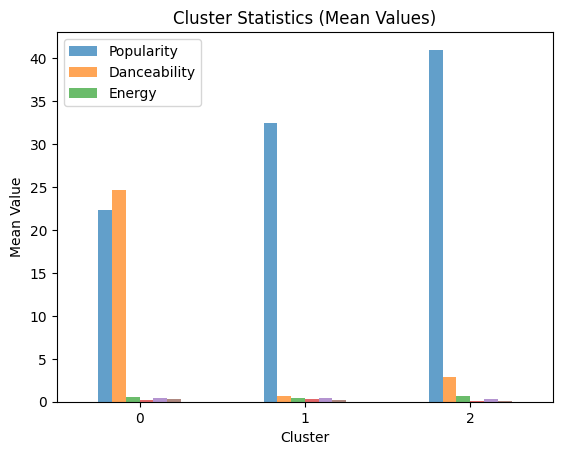

In [91]:
linkage_method="single"
hier_clustering = AgglomerativeClustering(n_clusters=3, linkage=linkage_method)
cluster_labels = hier_clustering.fit_predict(scaled_data)
silhouette_avg = silhouette_score(scaled_data, cluster_labels)
print(silhouette_avg)
filtered_datacopy['cluster'] = cluster_labels

# Find the most common track_genre in each cluster
most_common_genre = filtered_datacopy.groupby('cluster')['track_genre'].agg(lambda x: x.mode().iloc[0])

print("\nMost Common Track Genre in Each Cluster:")
print(most_common_genre)

cluster_stats = filtered_datacopy.groupby('cluster').agg({
    'popularity': ['mean', 'std'],
    'danceability': ['mean', 'std'],
    'energy': ['mean', 'std'],
    # Add more columns as needed
})

print("Cluster Statistics:")
print(cluster_stats)

# Visualize summary statistics
# Simple bar plots for cluster statistics (mean values only)
cluster_stats_mean = cluster_stats.droplevel(1, axis=1)  # Drop the 'mean' and 'std' level in the columns
cluster_stats_mean.plot(kind='bar', y=['popularity', 'danceability', 'energy'], alpha=0.7)
plt.title('Cluster Statistics (Mean Values)')
plt.ylabel('Mean Value')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.legend(['Popularity', 'Danceability', 'Energy'])
plt.show()

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, Birch
# from sklearn.mixture import GaussianMixture
# from sklearn.metrics import silhouette_score, accuracy_score
# from tabulate import tabulate 
# import numpy as np
# from sklearn.metrics import davies_bouldin_score


# data = pd.read_csv("dataset.csv")
# accuracy_run=50
# chosen_genres = ["hip-hop", "rock", "classical"]
# filtered_data = data[data['track_genre'].isin(chosen_genres)]

# # Drop problematic columns
# filtered_data.drop(columns=["track_id", "artists", "album_name", "track_name", "track_genre"], inplace=True)

# # Preprocessing
# scaler = StandardScaler()
# scaled_data = filtered_data
# scaled_data2 = scaler.fit_transform(filtered_data)

# # Calculate PCA
# pca = PCA(n_components=2)
# pca_data = pca.fit_transform(scaled_data)

# best_cluster_results = []

# # KMeans
# kmeans = KMeans(n_clusters=3, random_state=42)
# cluster_labels = kmeans.fit_predict(scaled_data)
# silhouette_avg = silhouette_score(scaled_data, cluster_labels)
# accuracy = accuracy_score(data[data['track_genre'].isin(chosen_genres)].groupby('track_genre').ngroup(), cluster_labels)
# best_cluster_results.append(("KMeans", "n_clusters=3", silhouette_avg, accuracy, kmeans))

# # Hierarchical
# linkage_methods = ['ward', 'complete', 'average', 'single']
# for linkage_method in linkage_methods:
#     hier_clustering = AgglomerativeClustering(n_clusters=3, linkage=linkage_method)
#     cluster_labels = hier_clustering.fit_predict(scaled_data)
#     silhouette_avg = silhouette_score(scaled_data, cluster_labels)
#     davies_bouldin_index = davies_bouldin_score(scaled_data, cluster_labels)
#     accuracy_scores = []
#     for x in range(1,accuracy_run):
#        accuracy_scores.append(accuracy_score(data[data['track_genre'].isin(chosen_genres)].groupby('track_genre').ngroup(), cluster_labels))
#     accuracy=np.mean(accuracy_scores)
#     best_cluster_results.append(("Hierarchical", f"linkage={linkage_method}_n_clusters=3", silhouette_avg, accuracy, hier_clustering))

# # DBScan
# eps_values = [0.1, 0.5, 1.0]
# min_samples_values = [2, 5, 10]
# for eps_val in eps_values:
#     for min_samples_val in min_samples_values:
#         dbscan = DBSCAN(eps=eps_val, min_samples=min_samples_val)
#         cluster_labels = dbscan.fit_predict(scaled_data2)
#         if len(set(cluster_labels)) > 1:
#             silhouette_avg = silhouette_score(scaled_data2, cluster_labels)
#             accuracy_scores = []
#             for x in range(1,accuracy_run):
#                  accuracy_scores.append(accuracy_score(data[data['track_genre'].isin(chosen_genres)].groupby('track_genre').ngroup(), cluster_labels))
#             accuracy=np.mean(accuracy_scores)
#             best_cluster_results.append(("DBScan", f"eps={eps_val}_min_samples={min_samples_val}", silhouette_avg, accuracy, dbscan))

# # Birch
# thresholds = [0.1, 0.5, 1.0]
# branching_factors = [20, 50, 100]
# for threshold_val in thresholds:
#     for branching_factor_val in branching_factors:
#         birch = Birch(n_clusters=3, threshold=threshold_val, branching_factor=branching_factor_val)
#         cluster_labels = birch.fit_predict(scaled_data)
#         silhouette_avg = silhouette_score(scaled_data, cluster_labels)
#         accuracy_scores = []
#         for x in range(1,accuracy_run):
#             accuracy_scores.append(accuracy_score(data[data['track_genre'].isin(chosen_genres)].groupby('track_genre').ngroup(), cluster_labels))
#         accuracy=np.mean(accuracy_scores)
#         best_cluster_results.append(("Birch", f"n_clusters=3_threshold={threshold_val}_branching_factor={branching_factor_val}", silhouette_avg, accuracy, birch))

# # GMM
# covariance_types = ['full', 'tied', 'diag', 'spherical']
# for covariance_type_val in covariance_types:
#     gmm = GaussianMixture(n_components=3, covariance_type=covariance_type_val)
#     gmm.fit(scaled_data)
#     cluster_labels = gmm.predict(scaled_data)

#     silhouette_avg = silhouette_score(scaled_data, cluster_labels)
#     accuracy_scores = []
#     for x in range(1,accuracy_run):
#         accuracy_scores.append(accuracy_score(data[data['track_genre'].isin(chosen_genres)].groupby('track_genre').ngroup(), cluster_labels))
#     accuracy=np.mean(accuracy_scores)
#     best_cluster_results.append(("GMM", f"covariance_type={covariance_type_val}_n_components=3", silhouette_avg, accuracy, gmm))

# for method in set(result[0] for result in best_cluster_results):
#     best_result = max((result for result in best_cluster_results if result[0] == method), key=lambda x: x[2])
#     best_model = best_result[4]  # model is now at index 4 in the tuple
#     cluster_labels = best_model.fit_predict(scaled_data)

#     plt.figure(figsize=(8, 6))
#     if isinstance(best_model, KMeans):
#         for i in range(best_model.n_clusters):
#             plt.scatter(pca_data[cluster_labels == i, 0], pca_data[cluster_labels == i, 1], label=f'Cluster {i+1}')
#         plt.title(f'Best {method} Clustering Results (Silhouette Score: {best_result[2]:.2f}, Accuracy: {best_result[3]*100:.2f}%)')
#     elif isinstance(best_model, AgglomerativeClustering):
#         for i in range(best_model.n_clusters):
#             plt.scatter(pca_data[cluster_labels == i, 0], pca_data[cluster_labels == i, 1], label=f'Cluster {i+1}')
#         plt.title(f'Best {method} Clustering Results (Silhouette Score: {best_result[2]:.2f}, Accuracy: {best_result[3]*100:.2f}%)')
#     elif isinstance(best_model, DBSCAN):
#         plt.scatter(pca_data[:, 0], pca_data[:, 1], c=cluster_labels, cmap='viridis')
#         plt.colorbar(label='Cluster Label')
#         plt.title(f'Best {method} Clustering Results (Silhouette Score: {best_result[2]:.2f}, Accuracy: {best_result[3]*100:.2f}%)')
#     elif isinstance(best_model, Birch):
#         for i in range(len(set(cluster_labels))):
#             plt.scatter(pca_data[cluster_labels == i, 0], pca_data[cluster_labels == i, 1], label=f'Cluster {i+1}')
#         plt.title(f'Best {method} Clustering Results (Silhouette Score: {best_result[2]:.2f}, Accuracy: {best_result[3]*100:.2f}%)')
#     elif isinstance(best_model, GaussianMixture):
#         for i in range(best_model.n_components):
#             plt.scatter(pca_data[cluster_labels == i, 0], pca_data[cluster_labels == i, 1], label=f'Cluster {i+1}')
#         plt.title(f'Best {method} Clustering Results (Silhouette Score: {best_result[2]:.2f}, Accuracy: {best_result[3]*100:.2f}%)')

#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 2')
#     plt.legend()
#     # Adding model parameters to the plot
#     plt.text(0.95, 0.05, f'Parameters: {best_result[1]}', ha='right', va='bottom', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
#     plt.show()

# overall_best_result = max(best_cluster_results, key=lambda x: x[2])

# print(f"Overall best clustering method: {overall_best_result[0]} with parameters {overall_best_result[1]}")
# print(f"Overall best silhouette score: {overall_best_result[2]}")

# columns = ['Method', 'Parameters', 'Silhouette Score', 'Accuracy', 'Model']
# overall_best_result_df = pd.DataFrame([overall_best_result], columns=columns)

# print("Overall Best Clustering Result:")
# print(tabulate(overall_best_result_df, headers='keys', tablefmt='psql'))


In [93]:
# linkage_method="single"
# hier_clustering = AgglomerativeClustering(n_clusters=3, linkage=linkage_method)
# cluster_labels = hier_clustering.fit_predict(scaled_data)
# silhouette_avg = silhouette_score(scaled_data, cluster_labels)

# filtered_datacopy['cluster'] = cluster_labels
# most_common_genre = filtered_datacopy.groupby('cluster')['track_genre'].agg(lambda x: x.mode().iloc[0])

# print("\nMost Common Track Genre in Each Cluster:")
# print(most_common_genre)



Most Common Track Genre in Each Cluster:
cluster
0      hip-hop
1    classical
2    classical
Name: track_genre, dtype: object


In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, Birch
# from sklearn.mixture import GaussianMixture
# from sklearn.metrics import silhouette_score, accuracy_score
# from tabulate import tabulate 
# import numpy as np
# from sklearn.metrics import davies_bouldin_score
# data = pd.read_csv("dataset.csv")
# accuracy_run=70
# chosen_genres = ["hip-hop", "rock", "classical"]
# filtered_data = data[data['track_genre'].isin(chosen_genres)]

# # Drop problematic columns
# filtered_data.drop(columns=["track_id", "artists", "album_name", "track_name", "track_genre"], inplace=True)

# # Preprocessing
# scaler = StandardScaler()
# scaled_data = filtered_data
# scaled_data2 = scaler.fit_transform(filtered_data)

# # Calculate PCA
# pca = PCA(n_components=2)
# pca_data = pca.fit_transform(scaled_data)

# best_cluster_results = []

# # KMeans
# kmeans = KMeans(n_clusters=3, random_state=42)
# cluster_labels = kmeans.fit_predict(scaled_data)
# silhouette_avg = silhouette_score(scaled_data, cluster_labels)
# accuracy = accuracy_score(data[data['track_genre'].isin(chosen_genres)].groupby('track_genre').ngroup(), cluster_labels)
# best_cluster_results.append(("KMeans", "n_clusters=3", silhouette_avg, accuracy, kmeans))

# # Hierarchical
# linkage_methods = ['ward', 'complete', 'average', 'single']
# for linkage_method in linkage_methods:
#     hier_clustering = AgglomerativeClustering(n_clusters=3, linkage=linkage_method)
#     cluster_labels = hier_clustering.fit_predict(scaled_data)
#     silhouette_avg = silhouette_score(scaled_data, cluster_labels)
#     print(linkage_method)
#     print(silhouette_avg)
#     davies_bouldin_index = davies_bouldin_score(scaled_data, cluster_labels)
#     accuracy_scores = []
#     for x in range(1,accuracy_run):
#        accuracy_scores.append(accuracy_score(data[data['track_genre'].isin(chosen_genres)].groupby('track_genre').ngroup(), cluster_labels))
#     accuracy=np.mean(accuracy_scores)
#     best_cluster_results.append(("Hierarchical", f"linkage={linkage_method}_n_clusters=3", silhouette_avg, accuracy, hier_clustering))

# # DBScan
# eps_values = [0.1, 0.5, 1.0]
# min_samples_values = [2, 5, 10]
# for eps_val in eps_values:
#     for min_samples_val in min_samples_values:
#         dbscan = DBSCAN(eps=eps_val, min_samples=min_samples_val)
#         cluster_labels = dbscan.fit_predict(scaled_data2)
#         if len(set(cluster_labels)) > 1:
#             silhouette_avg = silhouette_score(scaled_data2, cluster_labels)
#             accuracy_scores = []
#             for x in range(1,accuracy_run):
#                  accuracy_scores.append(accuracy_score(data[data['track_genre'].isin(chosen_genres)].groupby('track_genre').ngroup(), cluster_labels))
#             accuracy=np.mean(accuracy_scores)
#             best_cluster_results.append(("DBScan", f"eps={eps_val}_min_samples={min_samples_val}", silhouette_avg, accuracy, dbscan))

# # Birch
# thresholds = [0.1, 0.5, 1.0]
# branching_factors = [20, 50, 100]
# for threshold_val in thresholds:
#     for branching_factor_val in branching_factors:
#         birch = Birch(n_clusters=3, threshold=threshold_val, branching_factor=branching_factor_val)
#         cluster_labels = birch.fit_predict(scaled_data)
#         silhouette_avg = silhouette_score(scaled_data, cluster_labels)
#         accuracy_scores = []
#         for x in range(1,accuracy_run):
#             accuracy_scores.append(accuracy_score(data[data['track_genre'].isin(chosen_genres)].groupby('track_genre').ngroup(), cluster_labels))
#         accuracy=np.mean(accuracy_scores)
#         best_cluster_results.append(("Birch", f"n_clusters=3_threshold={threshold_val}_branching_factor={branching_factor_val}", silhouette_avg, accuracy, birch))

# # GMM
# covariance_types = ['full', 'tied', 'diag', 'spherical']
# for covariance_type_val in covariance_types:
#     gmm = GaussianMixture(n_components=3, covariance_type=covariance_type_val)
#     gmm.fit(scaled_data)
#     cluster_labels = gmm.predict(scaled_data)

#     silhouette_avg = silhouette_score(scaled_data, cluster_labels)
#     accuracy_scores = []
#     for x in range(1,accuracy_run):
#         accuracy_scores.append(accuracy_score(data[data['track_genre'].isin(chosen_genres)].groupby('track_genre').ngroup(), cluster_labels))
#     accuracy=np.mean(accuracy_scores)
#     best_cluster_results.append(("GMM", f"covariance_type={covariance_type_val}_n_components=3", silhouette_avg, accuracy, gmm))

# for method in set(result[0] for result in best_cluster_results):
#     best_result = max((result for result in best_cluster_results if result[0] == method), key=lambda x: x[2])
#     best_model = best_result[4]  # model is now at index 4 in the tuple
#     cluster_labels = best_model.fit_predict(scaled_data)

#     plt.figure(figsize=(8, 6))
#     if isinstance(best_model, KMeans):
#         for i in range(best_model.n_clusters):
#             plt.scatter(pca_data[cluster_labels == i, 0], pca_data[cluster_labels == i, 1], label=f'Cluster {i+1}')
#         plt.title(f'Best {method} Clustering Results (Silhouette Score: {best_result[2]:.2f}, Accuracy: {best_result[3]*100:.2f}%)')
#     elif isinstance(best_model, AgglomerativeClustering):
#         for i in range(best_model.n_clusters):
#             plt.scatter(pca_data[cluster_labels == i, 0], pca_data[cluster_labels == i, 1], label=f'Cluster {i+1}')
#         plt.title(f'Best {method} Clustering Results (Silhouette Score: {best_result[2]:.2f}, Accuracy: {best_result[3]*100:.2f}%)')
#     elif isinstance(best_model, DBSCAN):
#         plt.scatter(pca_data[:, 0], pca_data[:, 1], c=cluster_labels, cmap='viridis')
#         plt.colorbar(label='Cluster Label')
#         plt.title(f'Best {method} Clustering Results (Silhouette Score: {best_result[2]:.2f}, Accuracy: {best_result[3]*100:.2f}%)')
#     elif isinstance(best_model, Birch):
#         for i in range(len(set(cluster_labels))):
#             plt.scatter(pca_data[cluster_labels == i, 0], pca_data[cluster_labels == i, 1], label=f'Cluster {i+1}')
#         plt.title(f'Best {method} Clustering Results (Silhouette Score: {best_result[2]:.2f}, Accuracy: {best_result[3]*100:.2f}%)')
#     elif isinstance(best_model, GaussianMixture):
#         for i in range(best_model.n_components):
#             plt.scatter(pca_data[cluster_labels == i, 0], pca_data[cluster_labels == i, 1], label=f'Cluster {i+1}')
#         plt.title(f'Best {method} Clustering Results (Silhouette Score: {best_result[2]:.2f}, Accuracy: {best_result[3]*100:.2f}%)')

#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 2')
#     plt.legend()
#     # Adding model parameters to the plot
#     plt.text(0.95, 0.05, f'Parameters: {best_result[1]}', ha='right', va='bottom', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
#     plt.show()

# overall_best_result = max(best_cluster_results, key=lambda x: x[2])

# print(f"Overall best clustering method: {overall_best_result[0]} with parameters {overall_best_result[1]}")
# print(f"Overall best silhouette score: {overall_best_result[2]}")

# columns = ['Method', 'Parameters', 'Silhouette Score', 'Accuracy', 'Model']
# overall_best_result_df = pd.DataFrame([overall_best_result], columns=columns)

# print("Overall Best Clustering Result:")
# print(tabulate(overall_best_result_df, headers='keys', tablefmt='psql'))


# #inkage=single_n_clusters=3



In [35]:
def print_column_data_types(dataframe):
    print("Column Name\tData Type")
    for column in dataframe.columns:
        print(f"{column}\t{dataframe[column].dtype}")

# Example usage:
# Assuming 'df' is your DataFrame
print_column_data_types(data)


Column Name	Data Type
Unnamed: 0	int64
track_id	object
artists	object
album_name	object
track_name	object
popularity	int64
duration_ms	int64
explicit	bool
danceability	float64
energy	float64
key	int64
loudness	float64
mode	int64
speechiness	float64
acousticness	float64
instrumentalness	float64
liveness	float64
valence	float64
tempo	float64
time_signature	int64
track_genre	object


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming chosen_genres is already defined
# Filter the dataset to include only chosen genres
filtered_data = data[data['track_genre'].isin(chosen_genres)]

# Calculate summary statistics
summary_stats = filtered_data.groupby('track_genre').agg({
    'popularity': ['mean', 'median', 'max'],
    'duration_ms': ['mean', 'median', 'max'],
    'danceability': ['mean', 'median', 'max'],
    'energy': ['mean', 'median', 'max'],
    'loudness': ['mean', 'median', 'max'],
    'speechiness': ['mean', 'median', 'max'],
    'acousticness': ['mean', 'median', 'max'],
    'instrumentalness': ['mean', 'median', 'max'],
    'liveness': ['mean', 'median', 'max'],
    'valence': ['mean', 'median', 'max'],
    'tempo': ['mean', 'median', 'max']
})

# Display summary statistics
print(summary_stats)




            popularity            duration_ms                    danceability  \
                  mean median max        mean    median      max         mean   
track_genre                                                                     
classical       13.055    3.0  79  233075.004  182545.5  2646866     0.381923   
hip-hop         37.759   58.0  99  206680.508  198955.0   620320     0.736154   

                             energy  ... instrumentalness  liveness         \
            median    max      mean  ...              max      mean median   
track_genre                          ...                                     
classical    0.377  0.797  0.189827  ...            0.982  0.166838  0.120   
hip-hop      0.753  0.964  0.682530  ...            0.912  0.192645  0.129   

                     valence                     tempo                    
               max      mean median    max        mean   median      max  
track_genre                                          

/tmp/ipykernel_5112/952172211.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='track_genre', y=feature, data=genre_data, palette=colors)
/tmp/ipykernel_5112/952172211.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='track_genre', y=feature, data=genre_data, palette=colors)
/tmp/ipykernel_5112/952172211.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='track_genre', y=feature, data=genre_data, palette=colors)


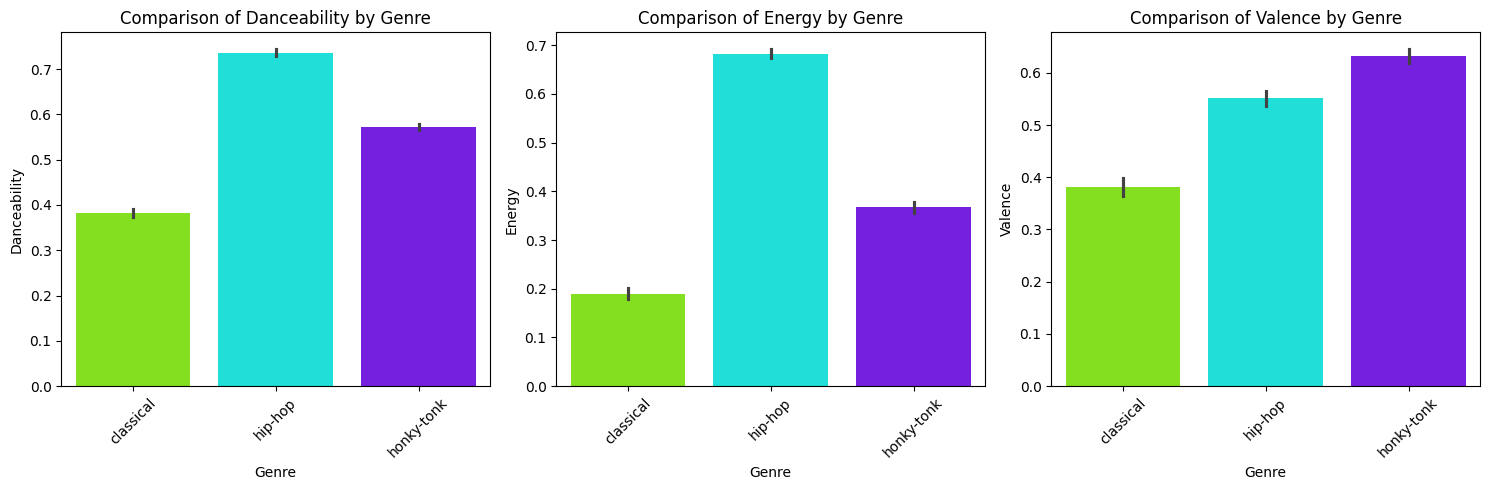

Most Popular Artist and Song in Each Genre:

Genre: ('classical', 16050)
Most Popular Artist: Ludovico Einaudi;Daniel Hope;I Virtuosi Italiani
Most Popular Song: Experience


Genre: ('hip-hop', 51664)
Most Popular Artist: Bizarrap;Quevedo
Most Popular Song: Quevedo: Bzrp Music Sessions, Vol. 52


Genre: ('honky-tonk', 52021)
Most Popular Artist: George Jones
Most Popular Song: He Stopped Loving Her Today



In [94]:
genre_data = data[data['track_genre'].isin(chosen_genres)]

# Summary statistics
summary_stats = genre_data.groupby('track_genre').describe()

# Visualization - Comparison of features by Genre using bar plots with colors
features = ['danceability', 'energy', 'valence']  # You can add more features here
num_genres = len(chosen_genres)

plt.figure(figsize=(15, 5))
colors = sns.color_palette("hsv", num_genres)  # Generate colors for each genre

for i, feature in enumerate(features, start=1):
    plt.subplot(1, len(features), i)
    sns.barplot(x='track_genre', y=feature, data=genre_data, palette=colors)
    plt.title(f'Comparison of {feature.capitalize()} by Genre')
    plt.xlabel('Genre')
    plt.ylabel(feature.capitalize())
    plt.xticks(rotation=45)
 
plt.tight_layout()
plt.show()

# Most popular artist and song in each genre
most_popular = genre_data.groupby('track_genre').apply(lambda x: x.nlargest(1, 'popularity'))

# Print most popular artist and song in each genre
print("Most Popular Artist and Song in Each Genre:")
for genre, row in most_popular.iterrows():
    print(f"\nGenre: {genre}")
    print(f"Most Popular Artist: {row['artists']}")
    print(f"Most Popular Song: {row['track_name']}\n")